In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score

start_date = '2010-05-4'
end_date = '2024-06-4'
ticker="AMZN"
data = yf.download(ticker,
                   start=start_date,
                   end=end_date,
                   interval="1d")

data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-05-04,6.781000,6.790500,6.419000,6.491500,6.491500,253356000
2010-05-05,6.400000,6.580500,6.377500,6.546500,6.546500,189162000
2010-05-06,6.500000,6.616500,6.030000,6.435500,6.435500,203780000
2010-05-07,6.398500,6.559000,6.188000,6.249000,6.249000,238552000
2010-05-10,6.486500,6.610500,6.463000,6.564500,6.564500,136122000
...,...,...,...,...,...,...
2024-05-28,179.929993,182.240005,179.490005,182.149994,182.149994,29927000
2024-05-29,181.699997,184.080002,181.550003,182.020004,182.020004,32009300
2024-05-30,181.309998,181.339996,178.360001,179.320007,179.320007,29249200


In [186]:
def get_current_price(symbol:str) -> np.float64:
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

current_price=get_current_price(ticker)

/tmp/ipykernel_56097/668293750.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return todays_data['Close'][0]


In [187]:
data = data.reset_index()
data = data[['Date', 'Close']]
data

,Date,Close
0,2010-05-04,6.491500
1,2010-05-05,6.546500
2,2010-05-06,6.435500
3,2010-05-07,6.249000
4,2010-05-10,6.564500
...,...,...
3540,2024-05-28,182.149994
3541,2024-05-29,182.020004
3542,2024-05-30,179.320007
3543,2024-05-31,176.440002


In [188]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

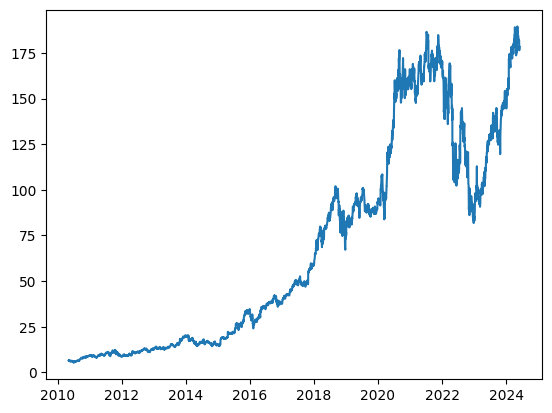

In [189]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [190]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 10
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date,,,,,,,,,,,
2010-05-18,6.314000,6.445500,6.426500,6.573500,6.693500,6.523000,6.564500,6.249000,6.435500,6.546500,6.491500
2010-05-19,6.229500,6.314000,6.445500,6.426500,6.573500,6.693500,6.523000,6.564500,6.249000,6.435500,6.546500
2010-05-20,5.985500,6.229500,6.314000,6.445500,6.426500,6.573500,6.693500,6.523000,6.564500,6.249000,6.435500
2010-05-21,6.136000,5.985500,6.229500,6.314000,6.445500,6.426500,6.573500,6.693500,6.523000,6.564500,6.249000
2010-05-24,6.106000,6.136000,5.985500,6.229500,6.314000,6.445500,6.426500,6.573500,6.693500,6.523000,6.564500
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,182.149994,180.750000,181.050003,183.130005,183.149994,183.539993,184.699997,183.630005,185.990005,187.070007,186.570007
2024-05-29,182.020004,182.149994,180.750000,181.050003,183.130005,183.149994,183.539993,184.699997,183.630005,185.990005,187.070007
2024-05-30,179.320007,182.020004,182.149994,180.750000,181.050003,183.130005,183.149994,183.539993,184.699997,183.630005,185.990005


In [191]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[  6.31400013,   6.4454999 ,   6.42649984, ...,   6.43550014,
          6.54650021,   6.4914999 ],
       [  6.22949982,   6.31400013,   6.4454999 , ...,   6.24900007,
          6.43550014,   6.54650021],
       [  5.98549986,   6.22949982,   6.31400013, ...,   6.56449986,
          6.24900007,   6.43550014],
       ...,
       [179.32000732, 182.02000427, 182.1499939 , ..., 184.69999695,
        183.63000488, 185.99000549],
       [176.44000244, 179.32000732, 182.02000427, ..., 183.53999329,
        184.69999695, 183.63000488],
       [178.33999634, 176.44000244, 179.32000732, ..., 183.1499939 ,
        183.53999329, 184.69999695]])

In [192]:
shifted_df_as_np.shape

(3535, 11)

In [193]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99040036, -0.98897156, -0.989178  , ..., -0.98908021,
        -0.98787414, -0.98847175],
       [-0.9913185 , -0.99040036, -0.98897156, ..., -0.99110662,
        -0.98908021, -0.98787414],
       [-0.99396967, -0.9913185 , -0.99040036, ..., -0.98767857,
        -0.99110662, -0.98908021],
       ...,
       [ 0.88938969,  0.9187264 ,  0.92013879, ...,  0.94784575,
         0.9362198 ,  0.96186229],
       [ 0.8580971 ,  0.88938969,  0.9187264 , ...,  0.93524178,
         0.94784575,  0.9362198 ],
       [ 0.87874141,  0.8580971 ,  0.88938969, ...,  0.93100426,
         0.93524178,  0.94784575]])

In [194]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3535, 10), (3535,))

In [195]:
X = dc(np.flip(X, axis=1))
X

array([[-0.98847175, -0.98787414, -0.98908021, ..., -0.98758078,
        -0.989178  , -0.98897156],
       [-0.98787414, -0.98908021, -0.99110662, ..., -0.989178  ,
        -0.98897156, -0.99040036],
       [-0.98908021, -0.99110662, -0.98767857, ..., -0.98897156,
        -0.99040036, -0.9913185 ],
       ...,
       [ 0.96186229,  0.9362198 ,  0.94784575, ...,  0.90492721,
         0.92013879,  0.9187264 ],
       [ 0.9362198 ,  0.94784575,  0.93524178, ...,  0.92013879,
         0.9187264 ,  0.88938969],
       [ 0.94784575,  0.93524178,  0.93100426, ...,  0.9187264 ,
         0.88938969,  0.8580971 ]])

In [196]:
split_index = int(len(X) * 0.8)

split_index

2828

In [197]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2828, 10), (707, 10), (2828,), (707,))

In [198]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2828, 10, 1), (707, 10, 1), (2828, 1), (707, 1))

In [199]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2828, 10, 1]),
 torch.Size([707, 10, 1]),
 torch.Size([2828, 1]),
 torch.Size([707, 1]))

In [200]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [201]:
train_dataset

In [202]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [203]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


In [204]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [205]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [206]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [207]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.525

Val Loss: 0.096
***************************************************

Epoch: 2
Batch 100, Loss: 0.061

Val Loss: 0.028
***************************************************

Epoch: 3
Batch 100, Loss: 0.015

Val Loss: 0.022
***************************************************

Epoch: 4
Batch 100, Loss: 0.007

Val Loss: 0.016
***************************************************

Epoch: 5
Batch 100, Loss: 0.004

Val Loss: 0.011
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.009
***************************************************

Epoch: 7
Batch 100, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 8
Batch 100, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 9
Batch 100, Loss: 0.001

Val Loss: 0.007
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.007
********************************

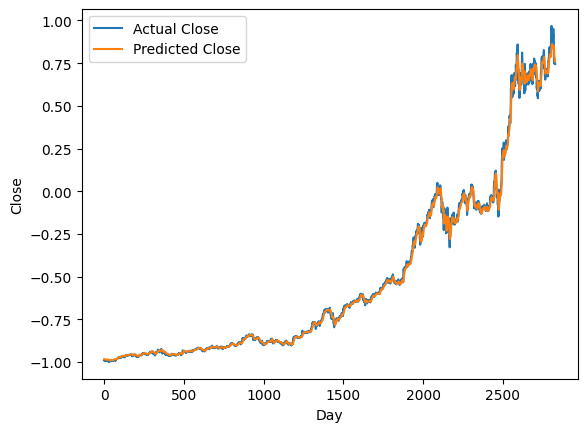

In [208]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [209]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  6.9535823 ,   6.94040565,   6.91638926, ..., 168.40861353,
       167.72119515, 167.24064796])

In [210]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  6.31399922,   6.22949751,   5.98549913, ..., 167.24699491,
       167.09350507, 166.03399724])

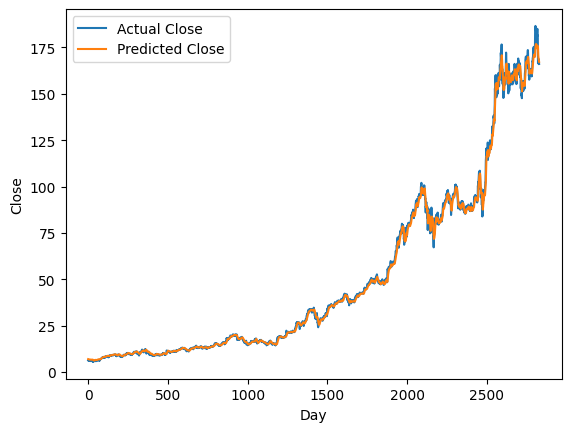

In [211]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [212]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([166.62204767, 165.83333039, 165.47280479, 165.16137071,
       165.03771209, 164.12432682, 163.02097181, 162.08011416,
       161.61613378, 162.22047673, 163.07799565, 163.5337804 ,
       164.10472094, 164.92408682, 166.38373247, 167.89590368,
       168.97562082, 169.53068574, 170.11824795, 170.82592501,
       171.43145836, 171.37096208, 171.23807103, 171.00936677,
       170.76933454, 170.89505578, 171.07105893, 170.89280116,
       169.55038489, 168.62326343, 168.39413128, 168.62824993,
       168.85423328, 168.76330234, 167.60702131, 166.74754948,
       165.90188516, 165.3198306 , 163.63551817, 163.08139678,
       163.14279821, 163.67148789, 163.75769016, 163.26590825,
       163.05043001, 163.41008338, 163.81328223, 165.5690404 ,
       167.06943931, 168.0248944 , 168.31509334, 168.80383617,
       167.85824436, 167.22683497, 167.48794325, 167.76132852,
       168.61640082, 168.13667099, 167.26211898, 166.63575643,
       167.13423638, 168.49447568, 169.80139948, 170.29

In [213]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([164.60549939, 165.17500267, 164.69850392, 164.94949109,
       162.09800851, 160.06100406, 159.38749741, 159.99749612,
       163.29350132, 165.28900097, 164.95899781, 165.80000477,
       167.48150853, 171.07850851, 173.53950261, 173.94999743,
       173.15600839, 173.90249677, 175.46449458, 176.27499558,
       174.20798984, 173.45750239, 172.85850799, 172.50000113,
       173.78950235, 174.41200297, 173.12600711, 167.78649691,
       167.18150116, 169.00250074, 170.80000508, 171.27599915,
       170.2899942 , 165.79800249, 165.05600141, 164.25200097,
       164.16299551, 159.48899929, 161.0500042 , 163.1004925 ,
       165.12150614, 164.43099932, 162.3150008 , 162.36650054,
       164.21400702, 164.99299817, 170.45100494, 172.33700457,
       172.20750368, 170.75300362, 171.7505011 , 166.77749591,
       166.01849466, 168.80349606, 169.62449668, 172.32850722,
       168.621508  , 165.90550024, 165.63749643, 169.19999686,
       173.85000412, 175.94949068, 174.44900401, 178.81

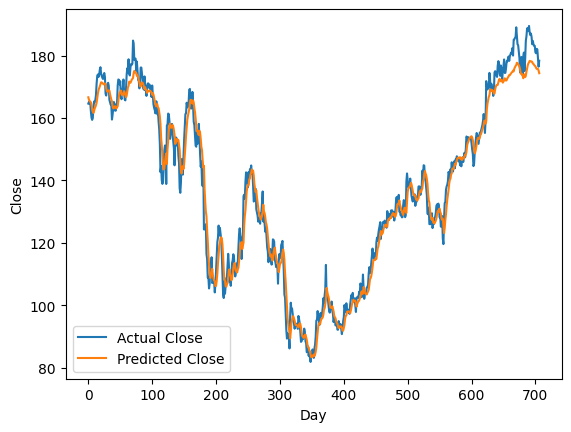

In [214]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [215]:
predicted_price = test_predictions[-1]

#r2 = r2_score(y_test, model(X_test).detach().numpy())
#print(model(X_test).detach().numpy())

In [216]:
def evaluate_model(model, X_test, y_test):
    # Ensure the model is in evaluation mode
    model.eval()

    # Perform the forward pass
    with torch.no_grad():
        predictions = model(X_test)

    # Detach the predictions tensor and convert to numpy
    predictions_np = predictions.detach().numpy()

    return mean_squared_error(y_test, predictions_np)

mse = evaluate_model(model, X_test, y_test)

In [217]:
print(f'{ticker} Stock Prices')
print(f'\nStock Price Now: {current_price: 0.2f}')
print(f'Predicted Stock Price: {predicted_price: 0.2f}')
print(f'Mean Squared Error on Test Data: {mse: 0.2f}')

AMZN Stock Prices

Stock Price Now:  181.15
Predicted Stock Price:  174.34
Mean Squared Error on Test Data:  0.00
